# Linking Affiliation with Network Data

In this notebook I want to start linking the universities/departments that appear in the network dataset to their affiliation ID that appears in the MAG dataset. There are few enough universities that where there are not exact matches on the basis of the name of the school, that I can do a little bit of work to manually find the appropriate ID. 

But first, I will try to make it easy for myself and normalize the university name and do a one to one match on the normalized name, see what proportion of schools I have and the proceed from there. 

Ultimately, this will be helpful because we will do a direct link from the network dataset and the MAG dataset by matching the authors name (direct matches only) and their most recent affiliation. Hopefully that will get us a more accurate look at the citations and publication counts for everyone. 

In [27]:
import os
import re
import csv
import glob
import json
import functions
import pandas as pd
import dask.dataframe as dd

os.chdir('/home/timothyelder/mag')

path = '/project/jevans/MAG_0802_2021_snap_shot/'

# read in the normalized faculty names from the network data
with open("data/faculty_names.txt", "r") as f:
    faculty_names = json.loads(f.read())

faculty_df_complete = pd.read_csv('data/faculty_df_complete.csv')
faculty_df_complete = faculty_df_complete[faculty_df_complete["year_observed"] >= 2020] # subset to just 2020-21 observations

departments = set(faculty_df_complete['current_dept'].to_list())
departments = list(departments)

In [28]:
dept_df = faculty_df_complete.groupby(['current_dept']).size().reset_index(name='counts')
dept_df["pct"] = (dept_df.counts / dept_df.counts.sum())*100
dept_df.sort_values(by=['pct'], ascending=False)

#dept_df[dept_df["current_dept"] == "University of Maryland"]

,current_dept,counts,pct
89,University of California-Los Angeles,75,1.427756
23,Florida International University,74,1.408719
88,University of California-Irvine,73,1.389682
130,University of North Carolina at Greensboro,71,1.351609
156,Virginia Tech,64,1.218351
...,...,...,...
119,University of Mississippi,9,0.171331
143,University of Texas at Dallas,8,0.152294
68,Southern Illinois University-Carbondale,7,0.133257
138,University of South Alabama,6,0.114220


## Normalizing Department Names

In [29]:
for idx, i in enumerate(departments):
    i = i.lower()
    i = re.sub(',|\.', '', i)
    i = re.sub('-', ' ', i)
    i = re.sub('\'', ' ', i)
    i = re.sub('\&', ' ', i)
    
    i = i.strip()
    departments[idx] = i
    
departments

['university of california los angeles',
 'university of california riverside',
 'middle tennessee state university',
 'northwestern university',
 'baylor university',
 'brandeis university',
 'university of oklahoma',
 'east tennessee state university',
 'fayetteville state university',
 'university of illinois at urbana champaign',
 'university of arkansas',
 'north carolina state university',
 'university of mississippi',
 'johns hopkins university',
 'yale university',
 'southern illinois university edwardsville',
 'old dominion university',
 'boston college',
 'university of miami',
 'the graduate center cuny',
 'university of iowa',
 'university of nevada reno',
 'new mexico state university',
 'south dakota state university',
 'loyola university chicago',
 'mississippi state university',
 'ball state university',
 'university of california irvine',
 'wichita state university',
 'university of north carolina at wilmington',
 'indiana university of pennsylvania',
 'syracuse univer

### Load MAG Affiliations and direct match

In [30]:
affiliations_df = dd.read_csv(path + 'Affiliations.txt',
                                           sep="\t", header=None,
                                           error_bad_lines=False,
                                           quoting=csv.QUOTE_NONE,
                                           encoding='utf-8')

new_columns = ['AffiliationId', 'Rank', 'NormalizedName', 'DisplayName',
               'GridId', 'OfficialPage', 'WikiPage', 'PaperCount', 
               'PaperFamilyCount', 'CitationCount', 'Iso3166Code', 'Latitude', 
               'Longitude', 'CreatedDate']

affiliations_df = affiliations_df.rename(columns=dict(zip(affiliations_df.columns, new_columns)))

mag_departments = affiliations_df[affiliations_df['NormalizedName'].isin(set(departments))].compute()

/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:737: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  **kwargs,
/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  path_info,


In [31]:
len(mag_departments)/len(departments) # 93.9% is not too shabby

1.0060975609756098

In [32]:
mag_departments.head()

,AffiliationId,Rank,NormalizedName,DisplayName,GridId,OfficialPage,WikiPage,PaperCount,PaperFamilyCount,CitationCount,Iso3166Code,Latitude,Longitude,CreatedDate
711,114395901,7179,university of nebraska lincoln,University of Nebraska–Lincoln,grid.24434.35,http://www.unl.edu/,http://en.wikipedia.org/wiki/University_of_Neb...,66965,65385,1739822,US,40.817500,-96.70139,2016-06-24
714,121847817,9794,the graduate center cuny,"The Graduate Center, CUNY",grid.253482.a,http://www.gc.cuny.edu/,"http://en.wikipedia.org/wiki/Graduate_Center,_...",6964,6619,131006,US,40.748330,-73.98333,2016-06-24
917,110378019,8472,southern illinois university carbondale,Southern Illinois University Carbondale,grid.263856.c,http://www.siu.edu/,http://en.wikipedia.org/wiki/Southern_Illinois...,27118,26721,542894,US,37.710426,-89.21931,2016-06-24
928,157725225,5687,university of illinois at urbana champaign,University of Illinois at Urbana–Champaign,grid.35403.31,http://www.illinois.edu/,http://en.wikipedia.org/wiki/University_of_Ill...,239875,229505,8303046,US,40.110540,-88.22841,2016-06-24
1116,149910238,8372,kent state university,Kent State University,grid.258518.3,http://www.kent.edu/,http://en.wikipedia.org/wiki/Kent_State_Univer...,27178,26568,564292,US,41.146410,-81.34174,2016-06-24


Lets check which departments did not get matched

In [33]:
no_match = []
for dept in departments:
    if dept not in mag_departments.NormalizedName.to_list():
        no_match.append(dept)
print(len(no_match))
print(set(no_match))

0
set()


### Manually Finding the no matched departments

In [34]:
affiliations_df[affiliations_df['NormalizedName'].str.contains('albany')].compute()

/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  path_info,


,AffiliationId,Rank,NormalizedName,DisplayName,GridId,OfficialPage,WikiPage,PaperCount,PaperFamilyCount,CitationCount,Iso3166Code,Latitude,Longitude,CreatedDate
4108,392282,7744,university at albany suny,"University at Albany, SUNY",grid.265850.c,http://www.albany.edu/,http://en.wikipedia.org/wiki/University_at_Alb...,22767,22128,745408,US,42.686190,-73.823880,2016-06-24
11974,36344538,12428,albany molecular research inc,"Albany Molecular Research, Inc.",grid.422244.6,http://www.amriglobal.com/,http://en.wikipedia.org/wiki/AMRI_Global,340,286,14688,US,42.703274,-73.874596,2016-06-24
12409,365282,10875,albany college of pharmacy and health sciences,Albany College of Pharmacy and Health Sciences,grid.413555.3,http://www.acphs.edu/,http://en.wikipedia.org/wiki/Albany_College_of...,2087,2070,46643,US,42.653206,-73.776276,2016-06-24
13184,113508548,10547,albany state university,Albany State University,grid.251990.6,http://www.asurams.edu/,http://en.wikipedia.org/wiki/Albany_State_Univ...,591,578,19473,US,31.569000,-84.142000,2016-06-24
18000,77920804,8697,albany medical college,Albany Medical College,NaN,http://www.amc.edu/,http://en.wikipedia.org/wiki/Albany_Medical_Co...,14466,14363,434888,US,42.653454,-73.776090,2016-06-24
21384,2799285576,19570,albany technical college,Albany Technical College,grid.468691.4,NaN,https://en.wikipedia.org/wiki/Albany_Technical...,1,1,0,US,31.553492,-84.174520,2018-05-17
22473,22128675,12737,albany law school,Albany Law School,grid.417841.f,http://www.albanylaw.edu/,http://en.wikipedia.org/wiki/Albany_Law_School,862,846,1117,US,42.652363,-73.777336,2016-06-24


# Merging Dataframes and Matching with MAG to get Authors

### Normalizing faculty names

In [35]:
pattern = r'(.+\,)(.+)' # regex for matching the first name and last name
aux_pattern = '(\S+)(.+)' # extra pattern for when the above doesn't match

faculty_df_complete = pd.read_csv("/home/timothyelder/mag/data/faculty_df_complete.csv")
faculty_names = faculty_df_complete['faculty_name'].to_list()

for idx,i in enumerate(faculty_names):
    i = re.sub(r';|:', ',', i)
    # match regex to the file_name string
    if re.search(pattern, i) == None:
        match = re.search(aux_pattern, i)
        new_name = match.group(2) + ' ' + match.group(1)
        new_name = re.sub('\/', 'l', new_name, count=1) # replaces / for l, a common error
        new_name = re.sub('\,', '', new_name, count=1)
        new_name = re.sub('\.', '', new_name, count=1)
        new_name = re.sub('\‘', '', new_name, count=1)
        new_name = new_name.lower()
        new_name = new_name.strip()

        faculty_names[idx] = new_name

    else:
        # match regex to the file_name string
        match = re.search(pattern, i)

        new_name = match.group(2) + ' ' + match.group(1)
        new_name = re.sub('\/', 'l', new_name, count=1) # replaces / for l, a common error
        new_name = re.sub('\,', '', new_name, count=1)
        new_name = re.sub('\.', '', new_name, count=1)
        new_name = re.sub('\‘', '', new_name, count=1)
        new_name = new_name.lower()
        new_name = new_name.strip()
        
        faculty_names[idx] = new_name

faculty_df_complete["faculty_name"] = faculty_names

In [36]:
faculty_df_complete = faculty_df_complete.rename(columns={"current_dept": "NormalizedName"})

In [37]:
departments = faculty_df_complete.NormalizedName.to_list()
for idx, i in enumerate(departments):
    i = i.lower()
    i = re.sub(',|\.', '', i)
    i = re.sub('-', ' ', i)
    i = i.strip()
    departments[idx] = i
    
faculty_df_complete["NormalizedName"] = departments

In [38]:
faculty_df_complete = faculty_df_complete.merge(mag_departments, how='left', on="NormalizedName")
faculty_df_complete.head()

,faculty_name,NormalizedName,source_dept,phd_year,highest_degree,interests,position,year_observed,AffiliationId,Rank,...,GridId,OfficialPage,WikiPage,PaperCount,PaperFamilyCount,CitationCount,Iso3166Code,Latitude,Longitude,CreatedDate
0,michael bader,american university,University of Michigan,2009,PhD,"['Demography', ' Urban Sociology']",Assistant Professor,2012,181401687.0,8973.0,...,grid.63124.32,http://www.american.edu/,http://en.wikipedia.org/wiki/American_University,16115.0,15529.0,274124.0,US,38.937054,-77.08692,2016-06-24
1,monica biradavolu,american university,Duke University,2005,PhD,"['', ' Global Health', ' HIV/AIDS']",Research Assistant Professor,2012,181401687.0,8973.0,...,grid.63124.32,http://www.american.edu/,http://en.wikipedia.org/wiki/American_University,16115.0,15529.0,274124.0,US,38.937054,-77.08692,2016-06-24
2,kim m blankenship,american university,Duke University,None,PhD,"['Applied Sociology/Evaluation Research', ' Po...","Professor, Chair",2012,181401687.0,8973.0,...,grid.63124.32,http://www.american.edu/,http://en.wikipedia.org/wiki/American_University,16115.0,15529.0,274124.0,US,38.937054,-77.08692,2016-06-24
3,andrea malkin brenner,american university,American University,None,PhD,"['Family', ' Sociology of Education']",Assistant Professor,2012,181401687.0,8973.0,...,grid.63124.32,http://www.american.edu/,http://en.wikipedia.org/wiki/American_University,16115.0,15529.0,274124.0,US,38.937054,-77.08692,2016-06-24
4,alan dahl,american university,University of Kentucky,2010,PhD,['Comparative Sociology/Historical Sociology'],Professorial Lecturer,2012,181401687.0,8973.0,...,grid.63124.32,http://www.american.edu/,http://en.wikipedia.org/wiki/American_University,16115.0,15529.0,274124.0,US,38.937054,-77.08692,2016-06-24


In [39]:
# Load authors dataframe from MAG
authors_df = dd.read_csv(path + 'Authors.txt',
                                           sep="\t", header=None,
                                           error_bad_lines=False,
                                           quoting=csv.QUOTE_NONE,
                                           encoding='utf-8')

new_columns = ['AuthorId', 'Rank',
               'NormalizedName', 'DisplayName',
               'LastKnownAffiliationId', 'PaperCount',
               'PaperFamilyCount', 'CitationCount', 'CreatedDate']

authors_df = authors_df.rename(columns=dict(zip(authors_df.columns, new_columns)))

/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:737: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  **kwargs,


In [40]:
# Filter authors dataframe for authors that appear in network data.
filtered_authors = authors_df[authors_df['NormalizedName'].isin(faculty_df_complete.faculty_name)].compute()

/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  path_info,


In [41]:
print(len(filtered_authors))
print(filtered_authors.head())

339359
      AuthorId   Rank     NormalizedName         DisplayName  \
471     184369  15782    charles kurzman     Charles Kurzman   
736     284723  16745   charles n halaby   Charles N. Halaby   
1602    633513  16244   karen a hegtvedt   Karen A. Hegtvedt   
4756   2033759  18047  georgi derluguian   Georgi Derluguian   
6408   2828213  18740  albert j bergesen  Albert J. Bergesen   

      LastKnownAffiliationId  PaperCount  PaperFamilyCount  CitationCount  \
471              114027177.0          79                79           1497   
736              135310074.0           9                 9           1029   
1602             150468666.0          48                48           1392   
4756             111979921.0          16                16             71   
6408                     NaN          11                11             11   

     CreatedDate  
471   2016-06-24  
736   2016-06-24  
1602  2016-06-24  
4756  2016-06-24  
6408  2016-06-24  


In [42]:
filtered_authors.columns

Index(['AuthorId', 'Rank', 'NormalizedName', 'DisplayName',
       'LastKnownAffiliationId', 'PaperCount', 'PaperFamilyCount',
       'CitationCount', 'CreatedDate'],
      dtype='object')

## Renaming Columns and Merging

What I want is to match names and their current affiliation Id

In [43]:
new_columns = ['NormalizedName', 'current_dept', 'source_dept', 'phd_year',
       'highest_degree', 'interests', 'position', 'year_observed',
       'LastKnownAffiliationId', 'Rank', 'DisplayName', 'GridId',
       'OfficialPage', 'WikiPage', 'PaperCount', 'PaperFamilyCount',
       'CitationCount', 'Iso3166Code', 'Latitude', 'Longitude', 'CreatedDate']

faculty_df_complete = faculty_df_complete.rename(columns=dict(zip(faculty_df_complete.columns, new_columns)))



In [44]:
df = pd.merge(faculty_df_complete, filtered_authors,  on=['NormalizedName', 'LastKnownAffiliationId'], how = "left", copy=False)
#len(set(df.AuthorId.to_list()))
df = df.dropna()
len(set(df.NormalizedName.to_list()))

2616

In [45]:
newest_df = filtered_authors[filtered_authors["LastKnownAffiliationId"].isin(mag_departments.AffiliationId)]

In [58]:
newest_df[newest_df["NormalizedName"].str.contains('danielle')]

,AuthorId,Rank,NormalizedName,DisplayName,LastKnownAffiliationId,PaperCount,PaperFamilyCount,CitationCount,CreatedDate
246684,1164340995,17204,danielle bessett,Danielle Bessett,63135867.0,29,29,347,2016-06-24
105623,3147025750,20504,danielle kane,Danielle Kane,219193219.0,2,2,0,2021-04-13


In [51]:
len(set(newest_df.NormalizedName.to_list()))/len(set(faculty_df_complete.NormalizedName.to_list()))

0.5013185985181464

In [52]:
newest_df

,AuthorId,Rank,NormalizedName,DisplayName,LastKnownAffiliationId,PaperCount,PaperFamilyCount,CitationCount,CreatedDate
471,184369,15782,charles kurzman,Charles Kurzman,114027177.0,79,79,1497,2016-06-24
736,284723,16745,charles n halaby,Charles N. Halaby,135310074.0,9,9,1029,2016-06-24
1602,633513,16244,karen a hegtvedt,Karen A. Hegtvedt,150468666.0,48,48,1392,2016-06-24
4756,2033759,18047,georgi derluguian,Georgi Derluguian,111979921.0,16,16,71,2016-06-24
13549,6101366,16127,joanna dreby,Joanna Dreby,392282.0,56,56,1507,2016-06-24
...,...,...,...,...,...,...,...,...,...
855224,3186726551,20463,geoff ward,Geoff Ward,12912129.0,2,2,2,2021-08-02
909291,3186854906,18517,omer r galle,Omer R. Galle,200719446.0,4,4,59,2021-08-02
927882,3186899265,20504,victor chen,Victor Chen,921990950.0,2,2,0,2021-08-02
1970,3186955294,20254,michael toney,Michael Toney,39422238.0,1,1,16,2021-08-02


In [55]:
mag_departments[mag_departments["AffiliationId"] == 39422238]

,AffiliationId,Rank,NormalizedName,DisplayName,GridId,OfficialPage,WikiPage,PaperCount,PaperFamilyCount,CitationCount,Iso3166Code,Latitude,Longitude,CreatedDate
20601,39422238,6531,university of illinois at chicago,University of Illinois at Chicago,grid.185648.6,http://www.uic.edu/,http://en.wikipedia.org/wiki/University_of_Ill...,118465,115030,3564311,US,41.871887,-87.64925,2016-06-24


# Loading the Fuzzy Matches Dataframes

In [8]:
# concatenating individual matched dataframes
match_path = r'/home/timothyelder/matches'
all_files = glob.glob(match_path + "/*.csv")
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files) # generate a list of files to concatenate

df_merged = pd.concat(df_from_each_file, ignore_index=True) # Concatenate pandas dataframes

names = df_merged['network_name'].to_list()

for idx, i in enumerate(names):
    i = re.sub('\.','', i)
    names[idx] = i

df_merged['network_name'] = names


candidate_matches = df_merged[df_merged['network_name'] == df_merged['NormalizedName']]
df_merged = df_merged[df_merged['network_name'] != df_merged['NormalizedName']]
df_merged = df_merged[df_merged['best_match_score'] >= .50]
candidate_matches = candidate_matches.append(df_merged)
len(candidate_matches)

95687

0.08654107423431204


<AxesSubplot:>

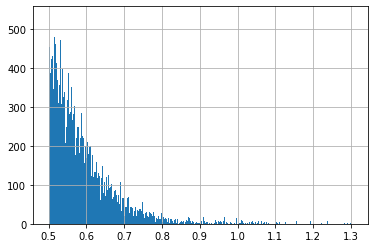

In [9]:
len(df_merged)
print(df_merged.best_match_score.std())
df_merged.best_match_score.min()
df_merged.best_match_score.max()
df_merged.best_match_score.hist(bins=1000)

In [10]:
candidate_matches

,Unnamed: 0,best_match_score,__id_left,__id_right,faculty_name,network_name,AuthorId,NormalizedName
65,2990,0.659706,74_left,1571423_right,"Blankenship, Kim M.",kim m blankenship,3.048999e+09,kim m blankenship
295,13260,0.712993,325_left,821791_right,"Pfohl, Stephen J.",stephen j pfohl,3.045411e+09,stephen j pfohl
302,13550,0.605695,332_left,310220_right,"Smith, David H.",david h smith,3.043000e+09,david h smith
308,13798,0.712993,338_left,821791_right,"Pfohl, Stephen J.",stephen j pfohl,3.045411e+09,stephen j pfohl
343,15578,0.712993,378_left,821791_right,"Pfohl, Stephen J.",stephen j pfohl,3.045411e+09,stephen j pfohl
...,...,...,...,...,...,...,...,...
2147649,881333,0.606326,24418_left,2389126_right,"Hartwell, Stephanie",stephanie hartwell,3.068725e+09,stephanie w hartwell
2147658,881688,0.537550,24427_left,2860951_right,"Dillaway, Heather E.",heather e dillaway,3.069277e+09,heather dell
2147763,885551,0.593478,24535_left,542508_right,"Gee, Richard L.",richard l gee,3.066568e+09,j l richard
2147787,886677,0.593478,24561_left,542508_right,"Gee, Richard L.",richard l gee,3.066568e+09,j l richard


In [11]:
#df_merged = df_merged[df_merged['best_match_score'] >= .50]
len(set(candidate_matches.AuthorId))

30512

In [14]:
# Load authors dataframe from MAG
authors_df = dd.read_csv(path + 'Authors.txt',
                                           sep="\t", header=None,
                                           error_bad_lines=False,
                                           quoting=csv.QUOTE_NONE,
                                           encoding='utf-8')

new_columns = ['AuthorId', 'Rank',
               'NormalizedName', 'DisplayName',
               'LastKnownAffiliationId', 'PaperCount',
               'PaperFamilyCount', 'CitationCount', 'CreatedDate']

authors_df = authors_df.rename(columns=dict(zip(authors_df.columns, new_columns)))

# Filter authors dataframe for authors that appear in network data.
filtered_authors = authors_df[authors_df['AuthorId'].isin(df_merged.AuthorId)].compute()
len(filtered_authors)

/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:737: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  **kwargs,
/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  path_info,


18513

In [24]:
filtered_authors

,AuthorId,Rank,NormalizedName,DisplayName,LastKnownAffiliationId,PaperCount,PaperFamilyCount,CitationCount,CreatedDate
9054,4137389,15940,timothy j biblarz,Timothy J. Biblarz,1174212.0,20,19,2247,2016-06-24
13089,5883335,17417,janet p stamatel,Janet P. Stamatel,143302722.0,28,28,343,2016-06-24
18556,8420247,17099,vera l zolberg,Vera L. Zolberg,102179633.0,20,20,336,2016-06-24
26719,12202749,14557,maureen t hallinan,Maureen T. Hallinan,107639228.0,112,111,5280,2016-06-24
43453,19867225,18292,tianna s paschel,Tianna S. Paschel,40347166.0,7,7,214,2016-06-24
...,...,...,...,...,...,...,...,...,...
821058,3186645146,19175,jukka savolainen,Jukka Savolainen,185443292.0,7,7,14,2021-08-02
833894,3186675539,20486,jenifer bratter,Jenifer Bratter,143302722.0,2,2,1,2021-08-02
855224,3186726551,20463,geoff ward,Geoff Ward,12912129.0,2,2,2,2021-08-02
909291,3186854906,18517,omer r galle,Omer R. Galle,200719446.0,4,4,59,2021-08-02


In [16]:
pattern = r'(.+\,)(.+)' # regex for matching the first name and last name
aux_pattern = '(\S+)(.+)' # extra pattern for when the above doesn't match

faculty_df_complete = pd.read_csv("/home/timothyelder/mag/data/faculty_df_complete.csv")
faculty_names = faculty_df_complete['faculty_name'].to_list()

for idx,i in enumerate(faculty_names):
    i = re.sub(r';|:', ',', i)
    # match regex to the file_name string
    if re.search(pattern, i) == None:
        match = re.search(aux_pattern, i)
        new_name = match.group(2) + ' ' + match.group(1)
        new_name = re.sub('\/', 'l', new_name, count=1) # replaces / for l, a common error
        new_name = re.sub('\,', '', new_name, count=1)
        new_name = re.sub('\.', '', new_name, count=1)
        new_name = re.sub('\‘', '', new_name, count=1)
        new_name = new_name.lower()
        new_name = new_name.strip()

        faculty_names[idx] = new_name

    else:
        # match regex to the file_name string
        match = re.search(pattern, i)

        new_name = match.group(2) + ' ' + match.group(1)
        new_name = re.sub('\/', 'l', new_name, count=1) # replaces / for l, a common error
        new_name = re.sub('\,', '', new_name, count=1)
        new_name = re.sub('\.', '', new_name, count=1)
        new_name = re.sub('\‘', '', new_name, count=1)
        new_name = new_name.lower()
        new_name = new_name.strip()
        
        faculty_names[idx] = new_name

faculty_df_complete["faculty_name"] = faculty_names

filtered_authors_2 = authors_df[authors_df['NormalizedName'].isin(faculty_df_complete["faculty_name"])].compute()

filtered_authors_2.head()

/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  path_info,


,AuthorId,Rank,NormalizedName,DisplayName,LastKnownAffiliationId,PaperCount,PaperFamilyCount,CitationCount,CreatedDate
471,184369,15782,charles kurzman,Charles Kurzman,114027177.0,79,79,1497,2016-06-24
736,284723,16745,charles n halaby,Charles N. Halaby,135310074.0,9,9,1029,2016-06-24
1602,633513,16244,karen a hegtvedt,Karen A. Hegtvedt,150468666.0,48,48,1392,2016-06-24
4756,2033759,18047,georgi derluguian,Georgi Derluguian,111979921.0,16,16,71,2016-06-24
6408,2828213,18740,albert j bergesen,Albert J. Bergesen,NaN,11,11,11,2016-06-24


In [17]:
filtered_authors = filtered_authors.append(filtered_authors_2)
len(filtered_authors)

357872

In [18]:
len(set(filtered_authors.NormalizedName))

13762

In [19]:
filtered_authors = filtered_authors[filtered_authors["LastKnownAffiliationId"].isin(mag_departments.AffiliationId)]
len(filtered_authors)

11443

In [20]:
len(set(filtered_authors.NormalizedName))/len(set(faculty_df_complete.faculty_name))

0.6551983927674535

In [21]:
filtered_authors[filtered_authors["NormalizedName"].str.contains('raudenbush')]

,AuthorId,Rank,NormalizedName,DisplayName,LastKnownAffiliationId,PaperCount,PaperFamilyCount,CitationCount,CreatedDate
389291,2285384011,12637,stephen w raudenbush,Stephen W. Raudenbush,40347166.0,170,162,50819,2016-06-24
304912,2319179191,20843,danielle t raudenbush,Danielle T. Raudenbush,40347166.0,1,1,9,2016-06-24
626977,2484153218,20238,danielle t raudenbush,Danielle T. Raudenbush,36258959.0,2,2,19,2016-08-23
705812,2618293213,16989,stephen w raudenbush,Stephen W. Raudenbush,136199984.0,4,4,379,2017-06-05
768216,2975987558,18688,stephen l raudenbush,Stephen L. Raudenbush,27837315.0,1,1,87,2019-10-03


In [22]:
authors2papers_df = dd.read_csv(path + 'PaperAuthorAffiliations.txt',
                                           sep="\t", header=None,
                                           error_bad_lines=False,
                                           quoting=csv.QUOTE_NONE,
                                           encoding='utf-8')

new_columns = ['PaperId', 'AuthorId',
               'AffiliationId', 'AuthorSequenceNumber',
               'OriginalAuthor', 'OriginalAffiliation']

authors2papers_df = authors2papers_df.rename(columns=dict(zip(authors2papers_df.columns, new_columns)))

filtered_authors2papers = authors2papers_df[authors2papers_df['AuthorId'].isin(filtered_authors['AuthorId'])].compute()

# filtered_authors2papers.to_csv('/home/timothyelder/mag/data/authors2papers.csv', index=False)

papers_df = dd.read_csv(path + 'Papers.txt',
                        sep="\t", header=None, dtype={16: 'object', 17: 'object',
                                                      18: 'float64', 19: 'float64',
                                                      20: 'float64', 24: 'object',
                                                       7: 'float64', 9: 'object',
                                                       8: 'string', 14: 'float64'},
                                                       error_bad_lines=False, quoting=csv.QUOTE_NONE,
                                                       encoding='utf-8')

new_columns =['PaperId', 'Rank', 'Doi', 'DocType',
              'PaperTitle', 'OriginalTitle',
              'BookTitle', 'Year', 'Date',
              'OnlineDate', 'Publisher',
              'JournalId', 'ConferenceSeriesId',
              'ConferenceInstanceId', 'Volume',
              'Issue', 'FirstPage', 'LastPage',
              'ReferenceCount', 'CitationCount',
              'EstimatedCitation', 'OriginalVenue',
              'FamilyId', 'FamilyRank', 'DocSubTypes',
              'CreatedDate']

papers_df = papers_df.rename(columns=dict(zip(papers_df.columns, new_columns)))

filtered_papers = papers_df[papers_df['PaperId'].isin(filtered_authors2papers['PaperId'])].compute()

# filtered_papers.to_csv('/home/timothyelder/mag/data/papers.csv', index=False)




/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:737: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  **kwargs,
/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  path_info,
/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:737: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  **kwargs,
/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  path_info,
/home/timothyelder/.conda/envs/soc_of_soc/lib/python3.7/site-packages/dask/dataframe/io/csv.py:134: DtypeWarning: Columns 

In [27]:
filtered_papers = filtered_papers[filtered_papers['DocType'] == "Journal"] 

In [25]:
filtered_authors2papers

,PaperId,AuthorId,AffiliationId,AuthorSequenceNumber,OriginalAuthor,OriginalAffiliation
3641,33518,1963213065,NaN,1,Jeffery R. Broadbent,NaN
6366,63235,614356337,78577930.0,2,Denise Kandel,Columbia University and New York Psychiatric I...
7984,79956,2203244522,130769515.0,1,Graham B. Spanier,Penn State-University Park#TAB#
10717,109026,2170308787,NaN,1,David Knox,NaN
15730,162270,2167722686,NaN,1,Robert Sampson,NaN
...,...,...,...,...,...,...
266423,3187040820,2922503776,NaN,2,Wendy Wang,NaN
272143,3187051285,2133141321,111979921.0,3,Klaus Weber,Northwestern U.
278540,3187062372,2972101691,NaN,9,Alice Lee,NaN
283509,3187071747,2099755627,193531525.0,1,Amitai Etzioni,The George Washington University


In [28]:
filtered_authors2papers.to_csv('/home/timothyelder/mag/data/authors2papers.csv', index=False)
filtered_papers.to_csv('/home/timothyelder/mag/data/papers.csv', index=False)